#[Exp-14] Transformer :  한국어 데이터로 챗봇 만들기
## 목차
Step 1. 데이터 수집하기

Step 2. 데이터 전처리하기

Step 3. SubwordTextEncoder 사용하기

Step 4. 모델 구성하기

Step 5. 모델 평가하기

## 회고


* import library

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
print("슝=3")

슝=3


In [2]:
# pandas 출력 방법 변경 (모든 행 출력)
pd.set_option('display.max_row', None)

# Step1. 데이터 수집

https://github.com/songys/Chatbot_data

In [3]:
# path_to_zip = tf.keras.utils.get_file(
#     'cornell_movie_dialogs.zip',
#     origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
#     extract=True)

# path_to_dataset = os.path.join(
#     os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

# path_to_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
# path_to_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')
# print("슝=3")

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Aiffel_data/Exp_Stage/Exp14_NLP5/PR/ChatbotData .csv") 
data.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


In [5]:
data.Q.describe()

count     11823
unique    11662
top         외로워
freq          4
Name: Q, dtype: object

In [6]:
data.A.describe()

count        11823
unique        7779
top       맛있게 드세요.
freq            22
Name: A, dtype: object

In [7]:
data.label.describe()

count    11823.000000
mean         0.803180
std          0.812012
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: label, dtype: float64

* 챗봇 트레이닝용 문답 페어 11,876개
* 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
* 중복값 존재

In [8]:
# # 사용할 샘플의 최대 개수
# MAX_SAMPLES = 50000
# print(MAX_SAMPLES)

# Step2. 데이터 전처리

* 구두점
* 영어
* 숫자

1)구두점

영여, 한글, 숫자, !?., 가 아닌 모든 문자열 (=구두점) 이 있는 Q컬럼 이나 A 컬럼에 속하는 새로운 데이터 프레임 생성

> 확인후 해당 열의 데이터를 삭제 할 것이다. (공백으로 대체)

In [9]:
data_punc = data[(data.Q.str.contains(r'[^a-zA-Z0-9가-힣ㄱ-하-ㅣ!?., ]')== True) | (data.A.str.contains(r'[^a-zA-Z0-9가-힣ㄱ-하-ㅣ!?., ]')== True )]
print(len(data_punc))
display(data_punc)

54


,Q,A,label
100,거지됐어,밥 사줄 친구를 찾아 보세요~,0
468,나 그지임,밥 사줄 친구를 찾아 보세요~,0
592,나는 좋은데 ….,현실의 벽에 부딪혔나봐요.,0
701,날씨가 진짜 덥다,시원한 물이라도 한 잔 드세요~,0
954,너무 더워,시원한 물이라도 한 잔 드세요~,0
1300,돈 어디갔지,퍼가요~,0
1313,돈이 엄떠,퍼가요~,0
1398,떠나요~ 제주도~,여행 좋죠!,0
1902,바람쐬러 정동진가~~,잘 놀다 오세요.,0
1932,반지 호수 모르는데,음~ 곰곰히 생각해보세요.,0


2) 영어 

* upper(): 영어 문자 대문자 변환 

SNS = SNS에 : SNS 공백

cc = CC는 : CC 공백

as = AS : 수리

cc


In [10]:
data_eng = data[(data.Q.str.contains(r'[a-zA-Z]')== True) | (data.A.str.contains(r'[a-zA-Z]')== True )]
print(len(data_eng))
display(data_eng)

42


,Q,A,label
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0
10,SNS보면 나만 빼고 다 행복해보여,자랑하는 자리니까요.,0
754,남친 SNS에 내 사진 없어,신경쓰지 마세요.,0
762,남친이 SNS에 내 사진에 안 올려,신경쓰지 마세요.,0
1401,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0


3)숫자

* 시간
[0-9시 ]

[0-9분 ]

[0-9초 ]

[0-9일 ]

[0-9주 ]

[0-9달 ]

[0-9년 ]

[0-9개월 ]

[주년] = [년]

[주일] = [일]


* 기타

[고3 ]

[중2], [중2병]= [중2병 ]

[1도]=[하나도 ], [1은]= [하나는 ]




In [11]:
data_eng = data[(data.Q.str.contains(r'[0-9]')== True) | (data.A.str.contains(r'[0-9]')== True )]
print(len(data_eng))
# display(data_eng)


415


In [12]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.upper().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence) # 공백여러개 공백하나처리

  # 구두점 처리
  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r'[^a-zA-Z0-9가-힣ㄱ-하-ㅣ!?., ]+', " ", sentence)

  # 영어 처리
  sentence = re.sub(r"SNS", " SNS ", sentence)
  sentence = re.sub(r"CC", " CC ", sentence)
  sentence = re.sub(r"AS", " AS ", sentence)

  # 숫자 처리

  # 단위통일
  sentence = re.sub(r"주년", " 년 ", sentence)
  sentence = re.sub(r"주일", " 일 ", sentence)


  # 시간
  sentence = re.sub(r"([0-9]+시)", r" \1 ", sentence)
  sentence = re.sub(r"([0-9]+분)", r" \1 ", sentence)
  sentence = re.sub(r"([0-9]+초)", r" \1 ", sentence)

  sentence = re.sub(r"([0-9]+일)", r" \1 ", sentence)
  sentence = re.sub(r"([0-9]+주)", r" \1 ", sentence)
  sentence = re.sub(r"([0-9]+달)", r" \1 ", sentence)
  sentence = re.sub(r"([0-9]+년)", r" \1 ", sentence)
  sentence = re.sub(r"([0-9]+개월)", r" \1 ", sentence)

  # 기타
  sentence = re.sub(r"고3", " 고3 ", sentence)
  sentence = re.sub(r"중2", " 중2병 ", sentence)
  sentence = re.sub(r"1도", " 하나도 ", sentence)
  sentence = re.sub(r"1은", " 하나는 ", sentence)

  sentence = re.sub(r'[" "]+', " ", sentence) # 공백여러개 공백하나처리
  sentence = sentence.strip() #문장 시작과 끝 공백 양쪽 제거
  return sentence
print("슝=3")

슝=3


### 전처리 적용과 확인

In [13]:
# data_copy = data.copy()
questions = []
answers = []

for q in data.Q:
  s1 = preprocess_sentence(q)
  questions.append(s1)
  # questions.append(preprocess_sentence(q))

for a in data.A:
  s2 = preprocess_sentence(a)
  answers.append(s2)

In [14]:
questions[:10]

['12시 땡 !',
 '1지망 학교 떨어졌어',
 '3박 4일 놀러가고 싶다',
 '3박 4일 정도 놀러가고 싶다',
 'PPL 심하네',
 'SD카드 망가졌어',
 'SD카드 안돼',
 'SNS 맞팔 왜 안하지ㅠㅠ',
 'SNS 시간낭비인 거 아는데 매일 하는 중',
 'SNS 시간낭비인데 자꾸 보게됨']

In [15]:
answers[:10]

['하루가 또 가네요 .',
 '위로해 드립니다 .',
 '여행은 언제나 좋죠 .',
 '여행은 언제나 좋죠 .',
 '눈살이 찌푸려지죠 .',
 '다시 새로 사는 게 마음 편해요 .',
 '다시 새로 사는 게 마음 편해요 .',
 '잘 모르고 있을 수도 있어요 .',
 '시간을 정하고 해보세요 .',
 '시간을 정하고 해보세요 .']

#### 구두점

In [16]:
# Questions에서 ~ 제거 되었음을 확인
for x in questions:
  if '~' in x :
    print(x)

In [17]:
# Answers에서 ~ 제거 되었음을 확인
for x in answers:
  if '~' in x :
    print(x)

#### 영어

In [18]:
  # sentence = re.sub(r"SNS", " SNS ", sentence)
  # sentence = re.sub(r"CC", " CC ", sentence)
  # sentence = re.sub(r"AS", " AS ", sentence)

In [19]:
for x in questions:
  if 'SNS' in x or 'AS' in x or 'CC' in x :
    print(x)

SNS 맞팔 왜 안하지ㅠㅠ
SNS 시간낭비인 거 아는데 매일 하는 중
SNS 시간낭비인데 자꾸 보게됨
SNS 보면 나만 빼고 다 행복해보여
남친 SNS 에 내 사진 없어
남친이 SNS 에 내 사진에 안 올려
SNS 를 끊어야 하는데 .
SNS 흔적
SNS 에서 다른 이성이랑 대화하는걸 보니 화가 나
그녀에 SNS 를 봤습니다 .
몰래 SNS 훔쳐보고 있는 나 한심해
오늘 또 헤어진 사람의 SNS 를 봤네
오늘도 전 여친 SNS 를 봤습니다
헤어진 남친의 SNS 행적
CC 레알 별로임 ?
같은 과에 내 이상형인 남자애가 있는데 CC 는 무리일까 ?
남자친구가 SNS 에 나 안 올려 .
여자친구가 나를 SNS 에 올리지 않아서 서운해 .
여자친구의 SNS 말투가 고민이야 .
좋아하는 사람 생기면 어떻게든 SNS 같은 거 알아내서 친신하고 그래 ?


In [20]:
for x in answers:
  if 'SNS' in x or 'AS' in x or 'CC' in x :
    print(x)

AS 맡기세요 .
AS 맡기세요 .
AS 센터에 맡겨보세요 .
AS 센터에 맡겨보세요 .
AS 센터에 맡겨보세요 .
AS 맡기세요 .
SNS 끊는게 힘들죠 .
SNS 흔적 삭제하세요 .
SNS 보지 마세요 .
SNS 는 보지 않는 게 좋겠어요 .
SNS 검색하지 마세요 .
SNS 를 삭제하는게 어떨까요 . 미련만 남을 뿐이에요 .
SNS 를 삭제하는게 어떨까요 . 미련만 남을 뿐이에요 .
AS 센터에 맡겨보세요 .
AS 맡기세요 .
SNS 끊으세요 .
CC 는 아무래도 제약이 있을 거예요 .
SNS 에 올리는 걸 안 좋아하는 사람도 있어요 .


#### 숫자 

In [21]:
number = ['0','1','2','3','4','5','6','7','8','9']
for x in answers:
  for num in number:
    if num in x :
      print(x)

처음 3초 가 중요해요 . 당신의 매력을 어필해보세요 .
나 자신에 집중하세요 . 언제나 1순위에 자신을 두세요 .
맛있게 먹으면 0칼로리 !
맛있게 먹으면 0칼로리 !
30분 씩 일찍 자는 습관을 들여보세요 .
30분 씩 일찍 자는 습관을 들여보세요 .
1년 힘내요 .
1년 힘내요 .
제가 1호팬 하겠습니다 .
제가 1호팬 하겠습니다 .
30분 씩 일찍 자는 습관을 들여보세요 .
30분 씩 일찍 자는 습관을 들여보세요 .
나 자신에 집중하세요 . 언제나 1순위에 자신을 두세요 .
낮잠은 20분 만 자세요 .
낮잠은 20분 만 자세요 .
낮잠은 20분 만 자세요 .
낮잠은 20분 만 자세요 .
처음 3초 가 중요해요 . 당신의 매력을 어필해보세요 .
첫인상은 상대방을 바라봤을때 3초 에 결정난데요 .
첫인상은 상대방을 바라봤을때 3초 에 결정난데요 .
2번 이상 입을 일이 있으면 맞추세요 .
2번 이상 입을 일이 있으면 맞추세요 .
환승은 30분 안에
환승은 30분 안에
환승은 30분 안에
환승은 30분 안에
환승은 30분 안에
환승은 30분 안에
2주 동안 고생했어요 .
365일 중에 하루일 뿐이에요 .
365일 중에 하루일 뿐이에요 .
365일 중에 하루일 뿐이에요 .
7전 8기 .
7전 8기 .
어느덧 2주 가 흘렀나봐요 .
어느덧 2주 가 흘렀나봐요 .
어느덧 2주 가 지났어요 .
어느덧 2주 가 지났어요 .
어느덧 3주 가 지났군요 .
어느덧 6일 이 되었나봐요 .
어느덧 2주 가 지났어요 .
새로운 나날을 보내는 것도 5개월 이 되었네요 .
환승은 30분 안에
환승은 30분 안에
100퍼센트 현실입니다 .
100퍼센트 현실입니다 .
1초 가 걸릴 수도 있고 평생이 걸릴 수도 있어요 .


In [22]:
# # 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
# def load_conversations():
#   id2line = {}
#   with open(path_to_movie_lines, errors='ignore') as file:
#     lines = file.readlines()
#   for line in lines:
#     parts = line.replace('\n', '').split(' +++$+++ ')
#     id2line[parts[0]] = parts[4]

#   inputs, outputs = [], []
#   with open(path_to_movie_conversations, 'r') as file:
#     lines = file.readlines()

#   for line in lines:
#     parts = line.replace('\n', '').split(' +++$+++ ')
#     conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

#     for i in range(len(conversation) - 1):
#       # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
#       inputs.append(preprocess_sentence(id2line[conversation[i]]))
#       outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

#       if len(inputs) >= MAX_SAMPLES:
#         return inputs, outputs
#   return inputs, outputs
# print("슝=3")

In [23]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
# questions, answers = load_conversations()
# print('전체 샘플 수 :', len(questions))
# print('전체 샘플 수 :', len(answers))

In [24]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


### 문장길이설정 

In [25]:
# 사용할 샘플의 최대 개수
MAX_LENGTH = 30
print(MAX_LENGTH)

30


#Step3. SubwordTextEncoder : 병렬 데이터 전처리

###1. 단어장 만들기

In [26]:
# 단어장  만들기

import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [27]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [28]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8152]
END_TOKEN의 번호 : [8153]


In [29]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8154


### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [30]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5754, 614, 2490, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7502, 7, 6265, 97, 1]


In [31]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [32]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [33]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8154
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### 3. 교사 강요(Teacher Forcing) 사용하기

In [34]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# Step 4. 모델 구성하기 : 트렌스포머 정의 및 학습

###1) scaled dot product


* positional matrix

In [35]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


❤️ plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')


최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터

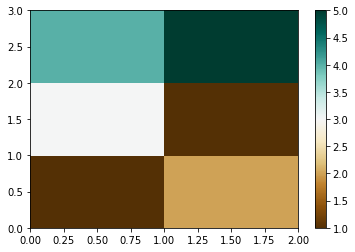

In [36]:
plt.pcolormesh([[1,2],[3,1], [4,5]], cmap='BrBG')
plt.colorbar()

In [37]:
sample_pos_encoding = PositionalEncoding(50, 512)

In [38]:
sample_pos_encoding.pos_encoding.numpy()[0]

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 8.41471016e-01,  5.40302277e-01,  8.21856260e-01, ...,
         1.00000000e+00,  1.03663238e-04,  1.00000000e+00],
       [ 9.09297466e-01, -4.16146815e-01,  9.36414719e-01, ...,
         1.00000000e+00,  2.07326477e-04,  1.00000000e+00],
       ...,
       [ 1.23573124e-01, -9.92335498e-01,  9.77189779e-01, ...,
         9.99987245e-01,  4.87215305e-03,  9.99988139e-01],
       [-7.68254697e-01, -6.40144348e-01,  7.31234014e-01, ...,
         9.99986708e-01,  4.97581484e-03,  9.99987602e-01],
       [-9.53752637e-01,  3.00592542e-01, -1.44028708e-01, ...,
         9.99986112e-01,  5.07947663e-03,  9.99987125e-01]], dtype=float32)

In [39]:
sample_pos_encoding.pos_encoding.numpy()

array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41471016e-01,  5.40302277e-01,  8.21856260e-01, ...,
          1.00000000e+00,  1.03663238e-04,  1.00000000e+00],
        [ 9.09297466e-01, -4.16146815e-01,  9.36414719e-01, ...,
          1.00000000e+00,  2.07326477e-04,  1.00000000e+00],
        ...,
        [ 1.23573124e-01, -9.92335498e-01,  9.77189779e-01, ...,
          9.99987245e-01,  4.87215305e-03,  9.99988139e-01],
        [-7.68254697e-01, -6.40144348e-01,  7.31234014e-01, ...,
          9.99986708e-01,  4.97581484e-03,  9.99987602e-01],
        [-9.53752637e-01,  3.00592542e-01, -1.44028708e-01, ...,
          9.99986112e-01,  5.07947663e-03,  9.99987125e-01]]],
      dtype=float32)

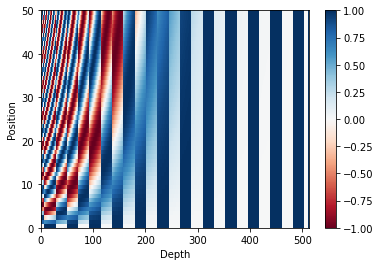

In [40]:
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

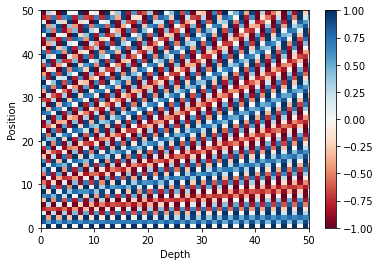

In [41]:
# sin cos 진동 양상 확대해서 보기 

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 50))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [42]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [43]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


### 2) multi-head-attention

In [44]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


###3 masking 

#### 마스킹

In [45]:
# 패딩 마스킹
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [46]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [47]:
# 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [48]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


#### 인코더 

In [49]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")


슝=3


In [50]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 디코더 

In [51]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [52]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 1. 모델 생성

* 데이터 개수 11000 개 > 논문대로 numlayer 6 개 , D_model = 512 수정



In [53]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    13642752    ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### 2. 손실 함수(Loss function)

In [54]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


### 3. 커스텀 된 학습률(Learning rate)

In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

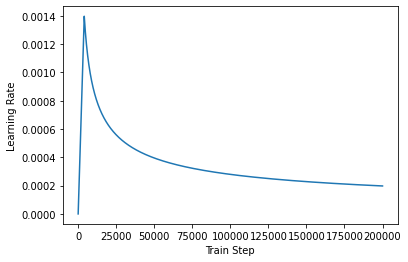

In [56]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

###4. 모델 컴파일

In [57]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


###5. 훈련하기

In [58]:
EPOCHS = 35
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/35
185/185 [==============================] - 53s 180ms/step - loss: 1.3407 - accuracy: 0.0253
Epoch 2/35
185/185 [==============================] - 33s 179ms/step - loss: 1.0694 - accuracy: 0.0496
Epoch 3/35
185/185 [==============================] - 33s 177ms/step - loss: 0.9807 - accuracy: 0.0506
Epoch 4/35
185/185 [==============================] - 33s 178ms/step - loss: 0.9399 - accuracy: 0.0526
Epoch 5/35
185/185 [==============================] - 33s 179ms/step - loss: 0.9066 - accuracy: 0.0545
Epoch 6/35
185/185 [==============================] - 33s 178ms/step - loss: 0.8699 - accuracy: 0.0566
Epoch 7/35
185/185 [==============================] - 33s 177ms/step - loss: 0.8301 - accuracy: 0.0590
Epoch 8/35
185/185 [==============================] - 33s 179ms/step - loss: 0.7842 - accuracy: 0.0616
Epoch 9/35
185/185 [==============================] - 33s 178ms/step - loss: 0.7305 - accuracy: 0.0653
Epoch 10/35
185/185 [==============================] - 33s 177ms/step - l

# Step 5. 모델 평가하기 : 챗봇 테스트


In [59]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [60]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [63]:
sentence_generation('PPL 심하네')

입력 : PPL 심하네
출력 : 눈살이 찌푸려지죠 .


'눈살이 찌푸려지죠 .'

In [62]:
sentence_generation("핸드폰 떨어뜨려서 고장 났나봐")

입력 : 핸드폰 떨어뜨려서 고장 났나봐
출력 : AS 맡기세요 .


'AS 맡기세요 .'

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.

숫자,영어,구두점 별로 분류하여 각각의 데이터 전처리 과정이 제일 어려웠다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.

트랜스포머 인코더 디코더의 전반적인 과정 이해 

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
* 1. 처음에 학습단계를 누락해서 결과가 너무 터무니없이 출력 됨.
* 2. epoch 10으로 설정했을때 accuracy가 0.07로 결과가 좋지 않음
* 3. 추가로 epoch 20 학습을 더 시킨 결과 그럴듯한 답변이 출력 됨.
* 4. 최종적으로 런타임 재실행하여 epoch 35로 결과 출력 ! 



>#### **루브릭평가 지표**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|  한국어 전처리를 통해 학습 데이터셋을 구축하였다. |공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
>|2|트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.| 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
>|3|한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.|



### - **자기 다짐**

* 코드 복기

### - **참고**
유튜브 링크 

https://youtu.be/mxGCEWOxfe8

https://youtu.be/URci3Eqz3hc

